In [1]:
from general import *
from exp2 import *
import time

random_state=42
np.random.seed(random_state)

## Experiment 

In [2]:
states=['ca','il','mo','tx']
labels = ['California','Illinois','Missouri','Texas']
alpha=.1
loss='mse'
B=100
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

In [3]:
data = pd.read_csv('data/car-insurance-public/data/mo-per-zip.csv')
data.head()

,zipcode,minority,companies_name,name,bi_policy_premium,pd_policy_premium,state_risk,white_non_hisp_pct,risk_difference,combined_premium
0,63005,False,21st Century Centennial Ins Co,FARMERS INS GRP,321,211.0,216.029693,87.9,315.970307,532.0
1,63010,False,21st Century Centennial Ins Co,FARMERS INS GRP,342,192.0,251.359806,93.9,282.640194,534.0
2,63011,False,21st Century Centennial Ins Co,FARMERS INS GRP,321,211.0,225.421778,88.9,306.578222,532.0
3,63012,False,21st Century Centennial Ins Co,FARMERS INS GRP,342,192.0,210.286312,97.2,323.713688,534.0
4,63013,False,21st Century Centennial Ins Co,FARMERS INS GRP,317,141.0,158.592140,100.0,299.407860,458.0


In [4]:
pvals=[]
times=[]

for s in tqdm(states):
    data = pd.read_csv('data/car-insurance-public/data/' + s + '-per-zip.csv')

    Z = np.array(data.state_risk).reshape((-1,1))
    Y = np.array(data.combined_premium).reshape((-1,1))
    X = (1*np.array(data.minority)).reshape((-1,1))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=random_state)
    Z_train, Z_test, _, _ = train_test_split(Z, Y, test_size=.3, random_state=random_state)

    ###Fitting models
    g1 = g()
    g1.fit(X_train, Z_train, Y_train)
    g2 = g()
    g2.fit(None, Z_train, Y_train)
    
    ###RBPT
    p = LogisticRegressionCV(cv=5, scoring='neg_log_loss', solver='liblinear', random_state=0).fit(Z_train, X_train.squeeze())
    H_test = np.sum(p.predict_proba(Z_test)*np.hstack((g1.predict(np.zeros(X_test.shape),Z_test).reshape(-1,1),
                                                       g1.predict(np.ones(X_test.shape),Z_test).reshape(-1,1))), axis=1).reshape(-1,1)
    pval_rbpt = get_pval_rbpt(X_test, Z_test, Y_test, H_test, g1, loss=loss)

    ###RBPT2
    h = get_h(Z_train, g1.predict(X_train,Z_train).squeeze())
    pval_rbpt2 = get_pval_rbpt2(X_test, Z_test, Y_test, g1, h, loss=loss)
    
    ###STFR
    pval_stfr = get_pval_stfr(X_test, Z_test, Y_test, g1, g2, loss=loss)


    ###GCM
    pval_gcm = get_pval_gcm(X_test, Z_test, Y_test, g2, p) 
    

    ###CRT
    pval_crt = get_pval_crt(X_test, Z_test, Y_test, p, g1, g2, B=B, loss=loss)


    ###CPT
    pval_cpt = get_pval_cpt(X_test, Z_test, Y_test, p, g1, g2, B=B, loss=loss)

    
    ###Storing
    pvals.append([pval_rbpt, pval_rbpt2, pval_stfr, pval_gcm, pval_crt, pval_cpt])

pvals=np.array(pvals)

100%|█████████████████████████████████████████████| 4/4 [00:31<00:00,  7.77s/it]


In [5]:
pvals_rbpt = pvals[:,0]
pvals_rbpt2 = pvals[:,1]
pvals_stfr = pvals[:,2]
pvals_gcm = pvals[:,3]
pvals_crt = pvals[:,4]
pvals_cpt = pvals[:,5]

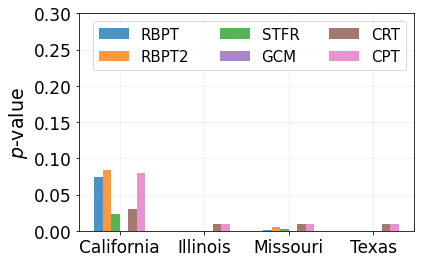

In [6]:
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

rects1 = plt.bar(x - width*5/8, pvals_rbpt, width*2/8, label='RBPT', color=colors[0], alpha=.8)
rects2 = plt.bar(x - width*3/8, pvals_rbpt2, width*2/8, label='RBPT2', color=colors[1], alpha=.8)
rects3 = plt.bar(x - width*1/8, pvals_stfr, width*2/8, label='STFR', color=colors[2], alpha=.8)
rects5 = plt.bar(x + width*1/8, pvals_gcm, width*2/8, label='GCM', color=colors[4], alpha=.8)
rects6 = plt.bar(x + width*3/8, pvals_crt, width*2/8, label='CRT', color=colors[5], alpha=.8)
rects7 = plt.bar(x + width*5/8, pvals_cpt, width*2/8, label='CPT', color=colors[6], alpha=.8)


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('$p$-value', size=19)
plt.xticks(x, labels, fontsize=17)
plt.legend(framealpha=0.75, prop={'size': 15}, ncol=3) 
#plt.axhline(y=alpha, color='black', linestyle='--', lw=1, alpha=.75)
plt.yticks(fontsize=17)
plt.ylim(0,.3)
plt.grid(alpha=.2)

plt.savefig('plots/exp22_revision.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()